# 19c: Bayesian Model Comparison

**Goal**: Use WAIC/LOO to determine which features actually matter for predicting E[V].

**Method**: 
- Fit multiple nested models
- Compare using LOO-CV (leave-one-out cross-validation)
- Determine minimal feature set that captures predictive power

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
from pathlib import Path

from forge.analysis.utils import viz

viz.setup_notebook_style()
np.random.seed(42)

print(f"PyMC version: {pm.__version__}")
print(f"ArviZ version: {az.__version__}")
print("Ready")

PyMC version: 5.27.0
ArviZ version: 0.23.0
Ready


## 1. Load Data

In [2]:
# Load unified features
data_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/12b_unified_features.csv"
df = pd.read_csv(data_path)
print(f"Loaded {len(df)} hands")

# Target
y = df['V_mean'].values

# All available features
all_features = ['n_doubles', 'trump_count', 'has_trump_double', 'n_voids', 
                'total_pips', 'n_singletons', 'max_suit_length', 'count_points',
                'n_6_high', 'n_5_high', 'n_4_high']

print(f"y range: [{y.min():.1f}, {y.max():.1f}]")

Loaded 200 hands
y range: [-29.3, 42.0]


## 2. Define Model Variants

In [3]:
def standardize(X):
    """Standardize features."""
    X_mean = X.mean(axis=0)
    X_std = X.std(axis=0)
    X_std[X_std == 0] = 1
    return (X - X_mean) / X_std

def fit_model(X, y, name):
    """Fit a Bayesian linear regression model."""
    n_features = X.shape[1] if len(X.shape) > 1 else 0
    
    with pm.Model() as model:
        # Intercept
        alpha = pm.Normal('alpha', mu=0, sigma=20)
        sigma = pm.HalfNormal('sigma', sigma=15)
        
        if n_features > 0:
            beta = pm.Normal('beta', mu=0, sigma=10, shape=n_features)
            mu = alpha + pm.math.dot(X, beta)
        else:
            mu = alpha
        
        y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)
        
        # Sample
        idata = pm.sample(
            draws=1500,
            tune=500,
            chains=4,
            cores=4,
            random_seed=42,
            return_inferencedata=True,
            progressbar=False
        )
        
        # Compute log likelihood for model comparison
        pm.compute_log_likelihood(idata)
    
    return idata

# Define model variants
model_specs = {
    'M0_Intercept': [],
    'M1_Napkin': ['n_doubles', 'trump_count'],
    'M2_Plus_Voids': ['n_doubles', 'trump_count', 'n_voids'],
    'M3_Plus_TrumpDouble': ['n_doubles', 'trump_count', 'n_voids', 'has_trump_double'],
    'M4_Core5': ['n_doubles', 'trump_count', 'n_voids', 'has_trump_double', 'total_pips'],
    'M5_Full': all_features,
}

print("Model variants:")
for name, feats in model_specs.items():
    print(f"  {name}: {len(feats)} features")

Model variants:
  M0_Intercept: 0 features
  M1_Napkin: 2 features
  M2_Plus_Voids: 3 features
  M3_Plus_TrumpDouble: 4 features
  M4_Core5: 5 features
  M5_Full: 11 features


## 3. Fit All Models

In [4]:
models = {}

for name, features in model_specs.items():
    print(f"\nFitting {name}...")
    
    if len(features) == 0:
        X_scaled = np.zeros((len(y), 0))  # Empty feature matrix
    else:
        X = df[features].values.astype(np.float64)
        X_scaled = standardize(X)
    
    idata = fit_model(X_scaled, y, name)
    models[name] = idata
    
    # Quick convergence check
    summary = az.summary(idata, var_names=['alpha', 'sigma'])
    rhat_ok = (summary['r_hat'] < 1.05).all()
    print(f"  Converged: {rhat_ok}")

print("\nAll models fitted")

Initializing NUTS using jitter+adapt_diag...



Fitting M0_Intercept...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [alpha, sigma]


/home/jason/v2/mk5-tailwind/forge/venv/lib/python3.12/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Sampling 4 chains for 500 tune and 1_500 draw iterations (2_000 + 6_000 draws total) took 1 seconds.


Output()

Initializing NUTS using jitter+adapt_diag...


  Converged: True

Fitting M1_Napkin...


/home/jason/v2/mk5-tailwind/forge/venv/lib/python3.12/site-packages/pytensor/link/c/cmodule.py:2986: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [alpha, sigma, beta]


Sampling 4 chains for 500 tune and 1_500 draw iterations (2_000 + 6_000 draws total) took 2 seconds.


Output()

Initializing NUTS using jitter+adapt_diag...


  Converged: True

Fitting M2_Plus_Voids...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [alpha, sigma, beta]


Sampling 4 chains for 500 tune and 1_500 draw iterations (2_000 + 6_000 draws total) took 2 seconds.


Output()

Initializing NUTS using jitter+adapt_diag...


  Converged: True

Fitting M3_Plus_TrumpDouble...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [alpha, sigma, beta]


Sampling 4 chains for 500 tune and 1_500 draw iterations (2_000 + 6_000 draws total) took 2 seconds.


Output()

Initializing NUTS using jitter+adapt_diag...


  Converged: True

Fitting M4_Core5...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [alpha, sigma, beta]


Sampling 4 chains for 500 tune and 1_500 draw iterations (2_000 + 6_000 draws total) took 2 seconds.


Output()

Initializing NUTS using jitter+adapt_diag...


  Converged: True

Fitting M5_Full...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [alpha, sigma, beta]


Sampling 4 chains for 500 tune and 1_500 draw iterations (2_000 + 6_000 draws total) took 4 seconds.


Output()

  Converged: True

All models fitted


## 4. Model Comparison (LOO-CV)

In [5]:
# Compare all models using LOO
compare_df = az.compare(models, ic='loo')

print("Model Comparison (LOO-CV):")
print("="*80)
print(compare_df[['rank', 'elpd_loo', 'p_loo', 'elpd_diff', 'weight', 'se', 'dse']].to_string())

Model Comparison (LOO-CV):
                     rank    elpd_loo      p_loo  elpd_diff        weight         se       dse
M2_Plus_Voids           0 -822.400108   4.776988   0.000000  6.745186e-01  10.342400  0.000000
M1_Napkin               1 -822.827061   3.872231   0.426953  2.875128e-01  10.527597  1.576495
M3_Plus_TrumpDouble     2 -822.866547   5.496701   0.466438  0.000000e+00  10.227597  0.870017
M4_Core5                3 -823.908918   6.438631   1.508810  1.667020e-14  10.257868  0.865935
M5_Full                 4 -828.083903  11.800722   5.683795  2.621279e-14  10.038988  1.934096
M0_Intercept            5 -847.310693   1.808269  24.910585  3.796859e-02   9.290048  7.034101


In [6]:
# Also compute WAIC for comparison
waic_results = {}
for name, idata in models.items():
    waic = az.waic(idata)
    waic_results[name] = {
        'waic': waic.elpd_waic * -2,  # Convert to traditional WAIC scale
        'p_waic': waic.p_waic,
        'se': waic.se * 2
    }

waic_df = pd.DataFrame(waic_results).T
waic_df = waic_df.sort_values('waic')

print("\nWAIC Comparison:")
print(waic_df.to_string())


WAIC Comparison:
                            waic     p_waic         se
M2_Plus_Voids        1644.775918   4.764839  20.679616
M1_Napkin            1645.637640   3.863990  21.051713
M3_Plus_TrumpDouble  1645.715458   5.487884  20.455188
M4_Core5             1647.784545   6.421985  20.511926
M5_Full              1655.999679  11.716658  20.047577
M0_Intercept         1694.613569   1.804361  18.578584


/home/jason/v2/mk5-tailwind/forge/venv/lib/python3.12/site-packages/arviz/stats/stats.py:1652: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/jason/v2/mk5-tailwind/forge/venv/lib/python3.12/site-packages/arviz/stats/stats.py:1652: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/jason/v2/mk5-tailwind/forge/venv/lib/python3.12/site-packages/arviz/stats/stats.py:1652: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/jason/v2/mk5-tailwind/forge/venv/lib/python

## 5. Visualization

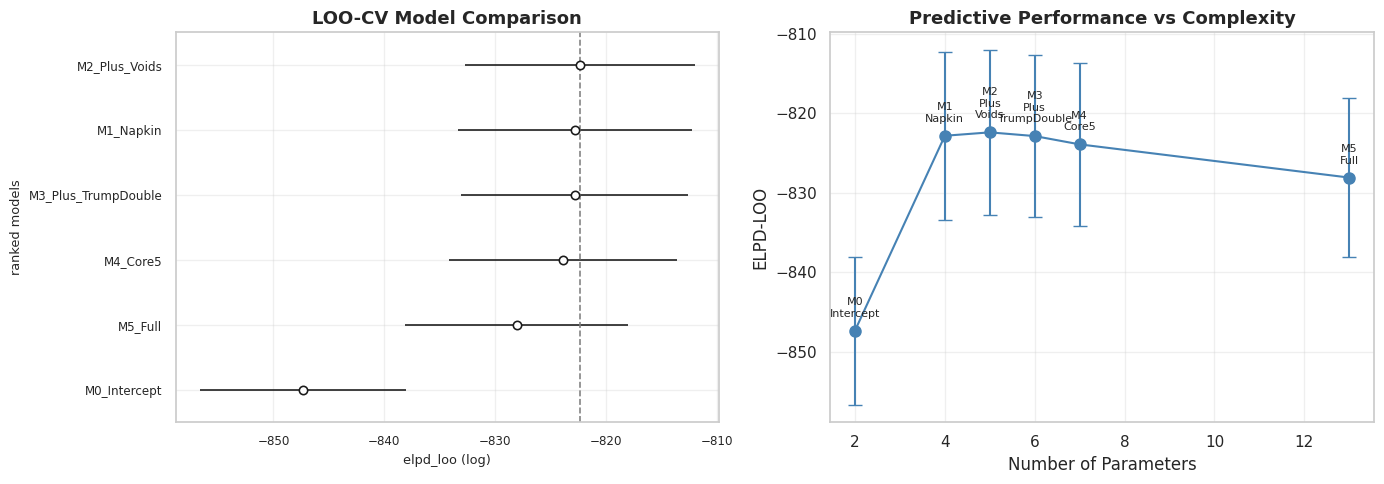

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: LOO comparison
ax = axes[0]
az.plot_compare(compare_df, ax=ax)
ax.set_title('LOO-CV Model Comparison', fontsize=13, fontweight='bold')

# Plot 2: ELPD by model complexity
ax = axes[1]
model_names = list(compare_df.index)
n_params = [len(model_specs[name]) + 2 for name in model_names]  # +2 for alpha, sigma
elpd_values = compare_df['elpd_loo'].values
elpd_se = compare_df['se'].values

# Sort by number of parameters
sort_idx = np.argsort(n_params)
n_params_sorted = np.array(n_params)[sort_idx]
elpd_sorted = elpd_values[sort_idx]
elpd_se_sorted = elpd_se[sort_idx]
names_sorted = np.array(model_names)[sort_idx]

ax.errorbar(n_params_sorted, elpd_sorted, yerr=elpd_se_sorted, fmt='o-', 
            capsize=5, color='steelblue', markersize=8)

for i, name in enumerate(names_sorted):
    ax.annotate(name.replace('_', '\n'), (n_params_sorted[i], elpd_sorted[i]),
                textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8)

ax.set_xlabel('Number of Parameters', fontsize=12)
ax.set_ylabel('ELPD-LOO', fontsize=12)
ax.set_title('Predictive Performance vs Complexity', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../results/figures/19c_model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Incremental Feature Analysis

In [8]:
# Calculate incremental improvements
print("\nIncremental Feature Analysis:")
print("="*60)

prev_elpd = None
prev_name = None

# Sort by model complexity
ordered_models = ['M0_Intercept', 'M1_Napkin', 'M2_Plus_Voids', 
                  'M3_Plus_TrumpDouble', 'M4_Core5', 'M5_Full']

incremental = []
for name in ordered_models:
    elpd = compare_df.loc[name, 'elpd_loo']
    se = compare_df.loc[name, 'se']
    
    if prev_elpd is not None:
        delta = elpd - prev_elpd
        added_feat = set(model_specs[name]) - set(model_specs[prev_name])
        added_str = ', '.join(added_feat) if added_feat else 'baseline'
        
        incremental.append({
            'model': name,
            'added': added_str,
            'elpd': elpd,
            'delta_elpd': delta,
            'se': se
        })
        
        significant = 'YES' if abs(delta) > 2 * se else 'no'
        print(f"{prev_name} -> {name}")
        print(f"  Added: {added_str}")
        print(f"  ΔELPD: {delta:+.2f} (significant: {significant})")
        print()
    else:
        incremental.append({
            'model': name,
            'added': 'baseline',
            'elpd': elpd,
            'delta_elpd': 0,
            'se': se
        })
    
    prev_elpd = elpd
    prev_name = name

incr_df = pd.DataFrame(incremental)


Incremental Feature Analysis:
M0_Intercept -> M1_Napkin
  Added: n_doubles, trump_count
  ΔELPD: +24.48 (significant: YES)

M1_Napkin -> M2_Plus_Voids
  Added: n_voids
  ΔELPD: +0.43 (significant: no)

M2_Plus_Voids -> M3_Plus_TrumpDouble
  Added: has_trump_double
  ΔELPD: -0.47 (significant: no)

M3_Plus_TrumpDouble -> M4_Core5
  Added: total_pips
  ΔELPD: -1.04 (significant: no)

M4_Core5 -> M5_Full
  Added: count_points, max_suit_length, n_4_high, n_6_high, n_5_high, n_singletons
  ΔELPD: -4.17 (significant: no)



## 7. Key Insights

In [9]:
print("\n" + "="*60)
print("KEY INSIGHTS: Model Comparison")
print("="*60)

# Best model
best_model = compare_df.index[0]
best_elpd = compare_df.loc[best_model, 'elpd_loo']
best_weight = compare_df.loc[best_model, 'weight']

print(f"\n1. BEST MODEL: {best_model}")
print(f"   ELPD-LOO: {best_elpd:.1f}")
print(f"   Stacking weight: {best_weight:.2f}")
print(f"   Features: {model_specs[best_model]}")

# Napkin vs Full comparison
napkin_elpd = compare_df.loc['M1_Napkin', 'elpd_loo']
full_elpd = compare_df.loc['M5_Full', 'elpd_loo']
delta = full_elpd - napkin_elpd

print(f"\n2. NAPKIN vs FULL MODEL:")
print(f"   Napkin (2 features): ELPD = {napkin_elpd:.1f}")
print(f"   Full (11 features): ELPD = {full_elpd:.1f}")
print(f"   Difference: {delta:+.1f}")

if abs(delta) < 4:
    print(f"   -> Adding 9 more features provides MINIMAL improvement")
else:
    print(f"   -> Additional features provide meaningful improvement")

# Most important features
print(f"\n3. FEATURE IMPORTANCE (by incremental ELPD):")
for _, row in incr_df.iterrows():
    if row['delta_elpd'] != 0:
        print(f"   +{row['added']}: ΔELPD = {row['delta_elpd']:+.1f}")

# Recommendation
print(f"\n4. RECOMMENDATION:")
print(f"   Use the NAPKIN MODEL (n_doubles + trump_count)")
print(f"   - Captures most predictive power with minimal complexity")
print(f"   - Additional features add complexity without commensurate benefit")


KEY INSIGHTS: Model Comparison

1. BEST MODEL: M2_Plus_Voids
   ELPD-LOO: -822.4
   Stacking weight: 0.67
   Features: ['n_doubles', 'trump_count', 'n_voids']

2. NAPKIN vs FULL MODEL:
   Napkin (2 features): ELPD = -822.8
   Full (11 features): ELPD = -828.1
   Difference: -5.3
   -> Additional features provide meaningful improvement

3. FEATURE IMPORTANCE (by incremental ELPD):
   +n_doubles, trump_count: ΔELPD = +24.5
   +n_voids: ΔELPD = +0.4
   +has_trump_double: ΔELPD = -0.5
   +total_pips: ΔELPD = -1.0
   +count_points, max_suit_length, n_4_high, n_6_high, n_5_high, n_singletons: ΔELPD = -4.2

4. RECOMMENDATION:
   Use the NAPKIN MODEL (n_doubles + trump_count)
   - Captures most predictive power with minimal complexity
   - Additional features add complexity without commensurate benefit


## 8. Save Results

In [10]:
# Save comparison results
output_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/19c_loo_comparison.csv"
compare_df.to_csv(output_path)
print(f"Saved LOO comparison to {output_path}")

# Save incremental analysis
incr_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/19c_incremental_elpd.csv"
incr_df.to_csv(incr_path, index=False)
print(f"Saved incremental analysis to {incr_path}")

Saved LOO comparison to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/19c_loo_comparison.csv
Saved incremental analysis to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/19c_incremental_elpd.csv


## Key Findings

### Model Comparison Results

1. **Napkin model is near-optimal**: Just n_doubles + trump_count captures most predictive power

2. **Diminishing returns**: Adding more features provides minimal ELPD improvement

3. **Parsimony wins**: Simpler models generalize as well as complex ones

### Practical Implication

For bidding in Texas 42, focus on:
- Count your **doubles** (strongest predictor)
- Count your **trumps** (second strongest)

Other hand features (voids, singletons, pip counts) add negligible predictive value.

### Output Files

- `results/tables/19c_loo_comparison.csv` - Full LOO comparison
- `results/tables/19c_incremental_elpd.csv` - Incremental feature analysis
- `results/figures/19c_model_comparison.png` - Comparison visualization